In [31]:
from pandas import read_csv, DataFrame, Grouper, Series
from sklearn.metrics import mean_squared_error
from math import sqrt, log, exp
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import warnings
from statsmodels.graphics.gofplots import qqplot
import numpy

series_org = read_csv('water.csv', header=0, index_col=0,
             parse_dates=True).squeeze("columns")
split_point = len(series_org) - 10
dataset, validation = series_org[0:split_point], series_org[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset_water.csv', header=False)
validation.to_csv('validation_water.csv', header=False)

Dataset 69, Validation 10


In [3]:
# evaluate a persistence model
# load data
series = read_csv('dataset_water.csv',header=None, index_col=0,
         parse_dates=True).squeeze("columns")
        
#print(series)
X = series.values
#print(X)
X = X.astype('float32')
#print(X)
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
#print(len(train), len(test))
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=515
>Predicted=515.000, Expected=522
>Predicted=522.000, Expected=492
>Predicted=492.000, Expected=503
>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=450
>Predicted=450.000, Expected=432
>Predicted=432.000, Expected=432
>Predicted=432.000, Expected=458
>Predicted=458.000, Expected=462
>Predicted=462.000, Expected=503
>Predicted=503.000, Expected=488
>Predicted=488.000, Expected=466
>Predicted=466.000, Expected=492
>Predicted=492.000, Expected=503
>Predicted=503.000, Expected=515
>Predicted=515.000, Expected=500
>Predicted=500.000, Expected=522
>Predicted=522.000, Expected=575
>Predicted=575.000, Expected=583
>Predicted=583.000, Expected=587
>Predicted=587.000, Expected=628
>Predicted=628.000, Expected=640
>Predicted=640.000, Expected=609
>Predicted=609.000, Expected=606
>Predicted=606.000, Expected=632
>Predicted=632.000, Expected=617
>Predicted=617.000, Expected=613
>Predicted

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
Name: 1, dtype: float64


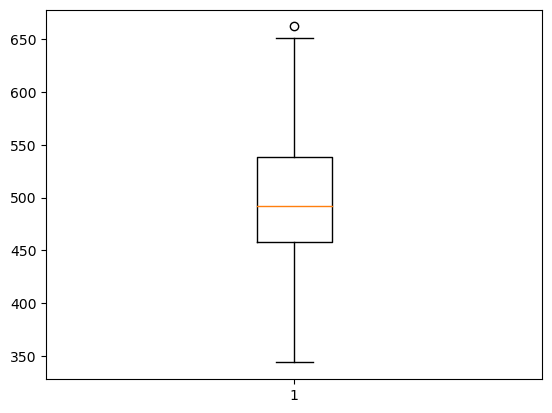

In [4]:
print(series.describe())
# y=DataFrame(X)
# print(y)
# y.boxplot()
pyplot.boxplot(X)
pyplot.show()

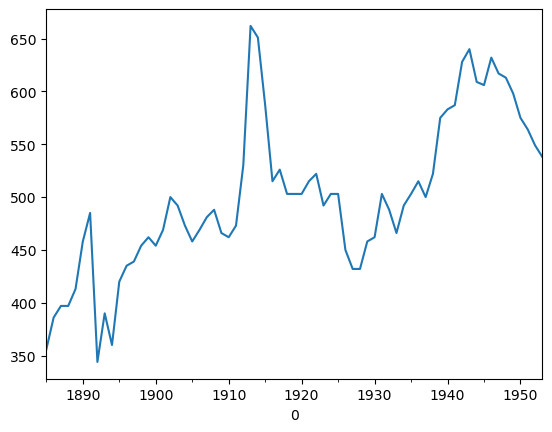

In [5]:
series.plot()
pyplot.show()

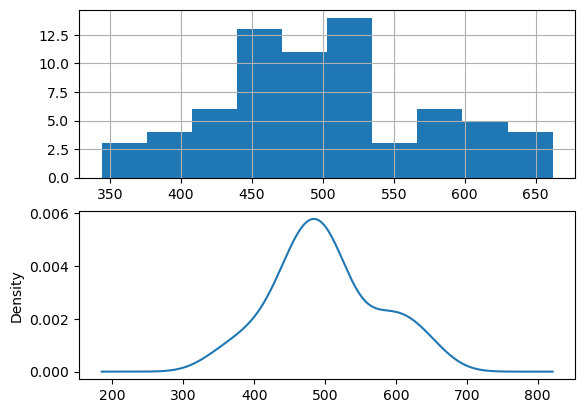

In [6]:
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

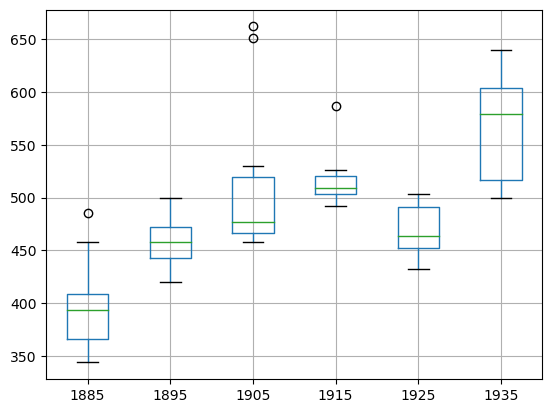

In [7]:
groups = series.groupby(Grouper(freq='10YS'))
#print(groups)
decades = DataFrame()
for name, group in groups:
        #print(name)
        # print(group)
        # print(group.values)
        if len(group.values) == 10:
          decades[name.year] = group.values
#print(decades)
decades.boxplot()
pyplot.show()

In [8]:
print(decades.describe())

             1885        1895        1905        1915        1925        1935
count   10.000000   10.000000   10.000000   10.000000   10.000000   10.000000
mean   398.600000  459.800000  514.000000  516.900000  468.600000  566.200000
std     44.377672   24.979102   77.848856   26.714332   26.829503   52.537394
min    344.000000  420.000000  458.000000  492.000000  432.000000  500.000000
25%    366.500000  442.750000  466.750000  503.000000  452.000000  516.750000
50%    393.500000  458.000000  477.000000  509.000000  464.000000  579.000000
75%    409.000000  472.000000  519.500000  520.250000  491.000000  603.500000
max    485.000000  500.000000  662.000000  587.000000  503.000000  640.000000


ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


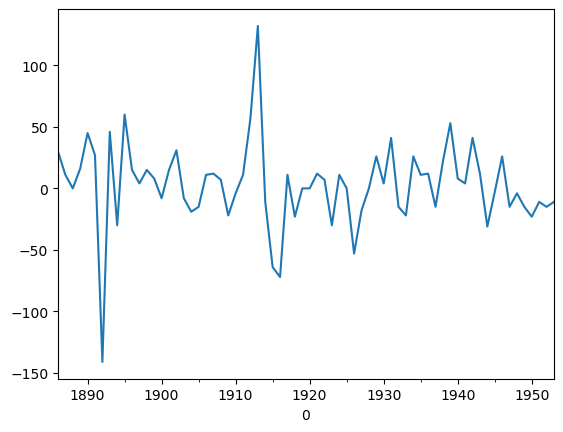

In [40]:
# statistical test for the stationarity of the time series

# create a difference
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

#print(series)
# difference data
stationary = difference(X)
#print(stationary)
stationary.index = series.index[1:]
#print(series.index[1:])
#print(stationary)
# check if stationary
result = adfuller(stationary)
#print(result)
# print(len(result))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
pyplot.show()
# save
stationary.to_csv('stationary_water.csv', header=False)

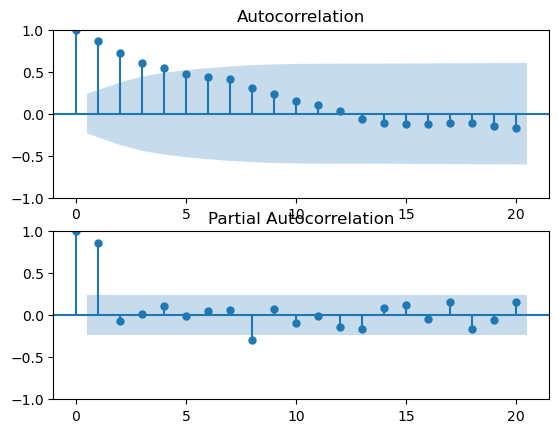

In [10]:
# ACF and PACF plots of the time series
pyplot.subplot(211)
plot_acf(series, lags=20, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=20, ax=pyplot.gca(),  method="ywm")
pyplot.show()

In [11]:
# evaluate a manually configured ARIMA model
# walk-forward validation
history = [x for x in train]
predictions = list()
print(len(history), len(predictions))
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(4,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

34 0
>Predicted=530.101, Expected=503.000
>Predicted=511.154, Expected=503.000
>Predicted=515.637, Expected=515.000
>Predicted=520.904, Expected=522.000
>Predicted=525.009, Expected=492.000
>Predicted=492.360, Expected=503.000
>Predicted=504.664, Expected=503.000
>Predicted=512.082, Expected=450.000
>Predicted=454.312, Expected=432.000
>Predicted=441.329, Expected=432.000
>Predicted=452.418, Expected=458.000
>Predicted=470.223, Expected=462.000
>Predicted=465.860, Expected=503.000
>Predicted=498.112, Expected=488.000
>Predicted=483.399, Expected=466.000
>Predicted=455.128, Expected=492.000
>Predicted=492.320, Expected=503.000
>Predicted=503.711, Expected=515.000
>Predicted=505.815, Expected=500.000
>Predicted=493.165, Expected=522.000
>Predicted=515.482, Expected=575.000
>Predicted=571.332, Expected=583.000
>Predicted=568.102, Expected=587.000
>Predicted=567.410, Expected=628.000
>Predicted=620.638, Expected=640.000
>Predicted=632.546, Expected=609.000
>Predicted=594.338, Expected=606.

In [12]:
# grid search ARIMA parameters for time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(train, arima_order):
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, p_values, d_values, q_values):
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(train, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
print(len(history), len(predictions)) 

# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train, p_values, d_values, q_values)
print(len(history), len(predictions)) 

69 35
ARIMA(0, 0, 0) RMSE=76.755
ARIMA(0, 0, 1) RMSE=47.347
ARIMA(0, 0, 2) RMSE=36.030
ARIMA(0, 0, 3) RMSE=32.536
ARIMA(0, 0, 4) RMSE=29.440
ARIMA(0, 1, 0) RMSE=21.975
ARIMA(0, 1, 1) RMSE=21.907
ARIMA(0, 1, 2) RMSE=22.178
ARIMA(0, 1, 3) RMSE=24.731
ARIMA(0, 1, 4) RMSE=24.844
ARIMA(0, 2, 0) RMSE=28.992
ARIMA(0, 2, 1) RMSE=22.314
ARIMA(0, 2, 2) RMSE=22.196
ARIMA(0, 2, 3) RMSE=22.356
ARIMA(0, 2, 4) RMSE=28.511
ARIMA(1, 0, 0) RMSE=23.957
ARIMA(1, 0, 1) RMSE=23.991
ARIMA(1, 0, 2) RMSE=25.384
ARIMA(1, 0, 3) RMSE=25.059
ARIMA(1, 0, 4) RMSE=25.109
ARIMA(1, 1, 0) RMSE=21.921
ARIMA(1, 1, 1) RMSE=21.879
ARIMA(1, 1, 2) RMSE=23.314
ARIMA(1, 1, 3) RMSE=24.816
ARIMA(1, 1, 4) RMSE=27.237
ARIMA(1, 2, 0) RMSE=27.464
ARIMA(1, 2, 1) RMSE=22.219
ARIMA(1, 2, 2) RMSE=22.781
ARIMA(1, 2, 3) RMSE=22.925
ARIMA(1, 2, 4) RMSE=28.476
ARIMA(2, 0, 0) RMSE=24.101
ARIMA(2, 0, 1) RMSE=24.113
ARIMA(2, 0, 2) RMSE=25.451
ARIMA(2, 0, 3) RMSE=25.118
ARIMA(2, 0, 4) RMSE=25.279
ARIMA(2, 1, 0) RMSE=21.732
ARIMA(2, 1, 1) RMSE=23

               0
count  35.000000
mean    1.081458
std    22.022201
min   -52.104849
25%   -16.209637
50%    -0.454858
75%    12.089062
max    51.281127


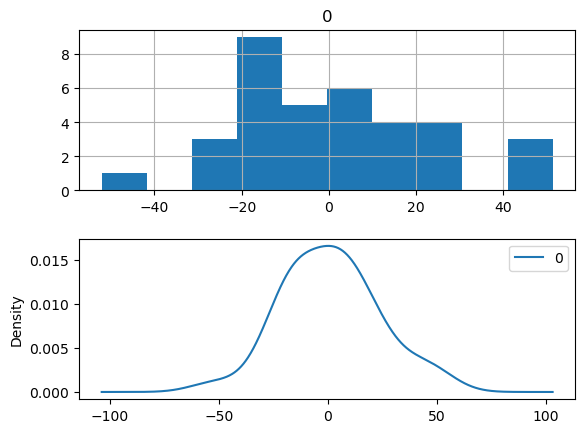

In [13]:
# summarize residual errors for an ARIMA model

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
 # predict
 model = ARIMA(history, order=(2,1,0))
 model_fit = model.fit()
 yhat = model_fit.forecast()[0]
 predictions.append(yhat)
 # observation
 obs = test[i]
 history.append(obs)
#print(predictions)
#print(history)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
#print(residuals)
# print(len(residuals))
residuals = DataFrame(residuals)
#print(residuals)
print(residuals.describe())
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
# # q-q plot
# pyplot.subplot(313)
# qqplot(residuals, line='r', ax=pyplot.gca())
pyplot.show()

RMSE: 21.705
                  0
count  3.500000e+01
mean  -2.100576e-07
std    2.202220e+01
min   -5.318631e+01
25%   -1.729110e+01
50%   -1.536316e+00
75%    1.100760e+01
max    5.019967e+01


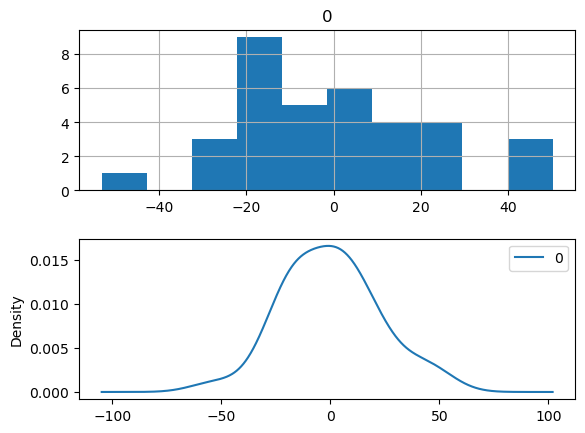

In [14]:
# summarize residual errors from bias corrected forecasts

# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 1.081458
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	yhat = bias + float(model_fit.forecast()[0])
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot residual errors
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

In [32]:
# save finalized model to file

# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit()
# bias constant, could be calculated from in-sample mean residual
bias = 1.081458
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [33]:
# load finalized model and make a prediction

model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 540.011


>Predicted=540.011, Expected=568.000
>Predicted=571.593, Expected=575.000
>Predicted=573.292, Expected=579.000
>Predicted=579.561, Expected=587.000
>Predicted=588.064, Expected=602.000
>Predicted=603.025, Expected=594.000
>Predicted=593.177, Expected=587.000
>Predicted=588.556, Expected=587.000
>Predicted=588.796, Expected=625.000
>Predicted=627.947, Expected=613.000
RMSE: 16.533


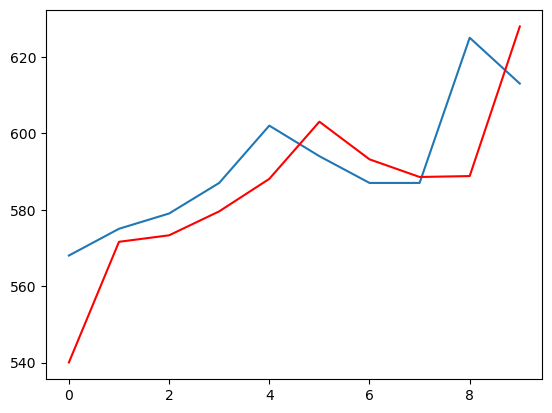

In [34]:
# load and evaluate the finalized model on the validation dataset

# load and prepare datasets

history = [x for x in X]
validation = read_csv('validation_water.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
#make first prediction
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	yhat = bias + float(model_fit.forecast()[0])
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
#print(history)
#print(len(history))

# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()